['Id' 'Fight_ID' 'winby' 'winner' 'corner' 'Prev' 'Age' 'Height' 'ID'
 'Name' 'Round1_Grappling_Reversals_Landed'
 'Round1_Grappling_Standups_Landed' 'Round1_Grappling_Takedowns_Landed'
 'Round1_Strikes_Total Strikes_Landed' 'Round2_Grappling_Reversals_Landed'
 'Round2_Grappling_Standups_Landed' 'Round2_Grappling_Takedowns_Landed'
 'Round2_Strikes_Total Strikes_Landed' 'Round3_Grappling_Reversals_Landed'
 'Round3_Grappling_Standups_Landed' 'Round3_Grappling_Takedowns_Landed'
 'Round3_Strikes_Total Strikes_Landed' 'Round4_Grappling_Reversals_Landed'
 'Round4_Grappling_Standups_Landed' 'Round4_Grappling_Takedowns_Landed'
 'Round4_Strikes_Total Strikes_Landed' 'Round5_Grappling_Reversals_Landed'
 'Round5_Grappling_Standups_Landed' 'Round5_Grappling_Takedowns_Landed'
 'Round5_Strikes_Total Strikes_Landed']
1451
1451
583
581
287
748
584
119


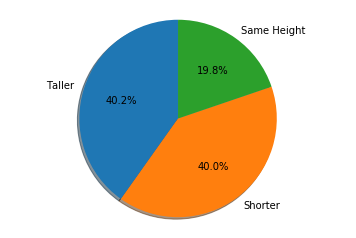

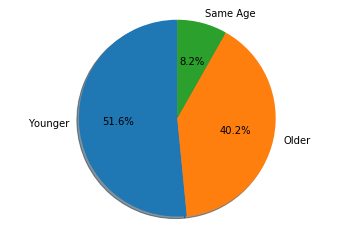

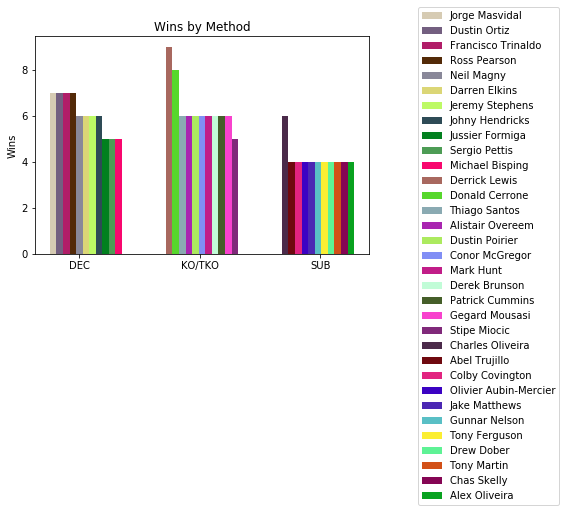

In [36]:
import numpy as np
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import random


# Read in the csv file.
ufc_data = pd.read_csv('UFC_Rounds.csv')
# Create a custom list of the first five and last five row numbers in the file.
first_last = [0,1,2,3,4] + [x for x in range(len(ufc_data) -1, len(ufc_data) -6, -1)]
# Display data for these rows.
ufc_data.iloc[first_last]

# Attempt to use numpy to sort by age
# Makes a new numpy array
fields = ufc_data.dtypes
ufc_np = np.array(ufc_data, dtype=fields)

# Get the most wins, including id, name, and win type
wins_series = ufc_data[["Name", "winby"]].groupby(["Name", "winby"]).size()

# Create a map that will be used to loop through the items
# And track most wins by type
win_types = {}

# Loop through data and create dictionary mapping
for record in wins_series.iteritems():        
    # First item is a tuple with name and win type
    win_type = record[0][1]
    # Get win type listings, for some reason there are 0s in the data
    if win_type != '0':
        # Get the wins type dict for this win type, or create a new one
        win_types[win_type] = win_types.get(win_type, {})
        # Name is in the first item of the tuple
        name = record[0][0]
        # Get the current wins (or set to 0) then increment
        win_types[win_type][name] = win_types[win_type].get(name, 0)
        win_types[win_type][name] = win_types[win_type][name] + record[1]
        
# Convert each of the win types to a Series, and get top 10 in each category.
for win_type in win_types:
    # Convert to series.
    series = pd.Series(win_types[win_type])
    # Sort and get top ten entries.
    win_types[win_type] = series.sort_values(ascending=False)[:11]
    
# This data needs to be moved around before it can be plotted
# Create a new mapping of fighter names : list. This is for plotting in the bar graph.
all_fighters = {}

for key in win_types.keys():
    for fighter_record in win_types[key].iteritems():        
        # Fighter name is first item in the tuple.
        name = fighter_record[0] 
        # Set name and an empty array of 0s for this fighter.
        all_fighters[fighter_record[0]] = np.zeros(3)

# Add win typer entries for each fighter to their array.
# This is because the bar chart needs equally shaped arrays
# For each fighter even if the entry for a win type is 0.
for fighter in all_fighters:
    # Index for tracking placement in fighter win type array
    index = 0
    
    for key in win_types.keys():       
        # Keep track of wether the fighters name was found in the win type
        # object. It may not be, then if not, there needs to be a 0 entry added for that win type
        # in the fighters win types array.
        found = False       
        
        for item in win_types[key].iteritems():
            # Item is a tuple that looks like ("Name", "# of wins")
            fighter_name = item[0] 
            fighter_wins = item[1]
            # Record of this currently iterated fighter found, add it to their win types array
            # and mark as found.
            if fighter == item[0]:
                all_fighters[fighter][index] = item[1]
                found = True
        
        index += 1       
        

# Import original data into pandas from csv
ufc_data = pd.read_csv("UFC_Rounds.csv")
# List of known named columns that must be dropped. Some fight round columns will be dropped later
columns_to_drop = ['Date', 'Event_ID', 'Last_round', 'Max_round', 'RStreak', 'HomeTown', 'Location', 'Weight']
# Drop afformentioned columns
ufc_data = ufc_data.drop(columns=columns_to_drop)

# Now we have many columns of round data. The only columns that we want to keep are either strikes landed or submissions
# landed. Which means we have to drop every column that doesn't have a label which matches this pattern:
# 'Round * _Landed'
for i in ufc_data.columns.values:
    # Check if this is a Round columnn:
    if i.startswith('Round'):
        # If the column describes a landed technique, keep it. Otherwise drop it
        if i.endswith('Landed'):
            pass
        
        else:
            ufc_data = ufc_data.drop(i, axis=1)

# To simplyfy the data set further, I'm only keeping the 'Round N Total Strikes Landed' columns
for i in ufc_data.columns.values:
    # Check if this is a strikes column
    if 'Strikes' in i:
        # If this is the total strikes landed column, keep it. Otherwise drop it
        if i.endswith('_Strikes_Total Strikes_Landed'):
            pass
        
        else:
            ufc_data = ufc_data.drop(i, axis=1)
            
# Since I'm also comparing wins and losses, I will have to remove the 'draw' and 'no contest' fights to simplify things
for index, row in ufc_data.iterrows():
    # Check if fight is a draw or no contest, if so remove the record
    if row.loc['winner'] == 'draw' or row.loc['winner'] == 'no contest':
        ufc_data = ufc_data.drop(index)
        
# There are still 30 columns, which is signifigantly less than before, but hard to see in jupyter.
# So for information purposes I will also print the columns
print(ufc_data.columns.values)
            
ufc_data.head(20)


# We want to determine if height and age is a factor in winning a match.
# To do this, we first need to group our data by the match (Fight_ID)

# Get column numbers for height and age
height_col = ufc_data.columns.get_loc('Height')
age_col = ufc_data.columns.get_loc('Age')
fight_id_col = ufc_data.columns.get_loc('Fight_ID')
corner_col = ufc_data.columns.get_loc('corner')
winner_col = ufc_data.columns.get_loc('winner')

# Create numpy array for winners and losers
ufc_np_arr = np.array(ufc_data)
# Sort the array by Fight ID
ufc_np_arr = np.array(sorted(ufc_np_arr, key=lambda x: x[fight_id_col]))
# Make boolean indexed array for fight winners
winners_idx = (ufc_np_arr[:, corner_col] == ufc_np_arr[:, winner_col])
np_winners = ufc_np_arr[winners_idx]
# Make a boolean index array of fight losers
losers_idx = (ufc_np_arr[:, corner_col] != ufc_np_arr[:, winner_col])
np_losers = ufc_np_arr[losers_idx]
# Just to check, print lengths of winers and losers
print(len(np_losers))
print(len(np_winners))

# To make iterations clearer
num_fights = len(np_winners)

# Tally totals for height difference in winners
taller_total = 0
shorter_total = 0
younger_total = 0
older_total = 0

# Get totals for winners by age and height
for i in range(0, num_fights):
    if np_winners[i][height_col] > np_losers[i][height_col]:
        taller_total += 1
    
    elif np_winners[i][height_col] < np_losers[i][height_col]:    
        shorter_total +=1
    
    if np_winners[i][age_col] < np_losers[i][age_col]:
        younger_total += 1
        
    elif np_winners[i][age_col] > np_losers[i][age_col]:
        older_total += 1

# Get same totals for height, age
same_height = len(np_winners) - (taller_total + shorter_total)
same_age = len(np_winners) - (younger_total + older_total)
print(taller_total)
print(shorter_total)
print(same_height)
print(younger_total)
print(older_total)  
print(same_age)


class UFCData(object):
    def __init__(self):
        pass

    
class UFCDataCharts(object):
    def __init__(self):
        pass
    
    @staticmethod
    def _random_color():
        return int(random.random() * 256) / 256
    
    @classmethod
    def get_rgb(cls):
        return (cls._random_color(), cls._random_color(), cls._random_color())
    
    def pie_chart(self, labels, totals):
        percentages = [((x / np.sum(totals)) * 100) for x in totals]
        fig, ax = plt.subplots()
        ax.pie(totals, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
        ax.axis('equal')
        plt.show()
    
    def bar_chart(self, data_map, xlabels, ylabel, title, width=.15):                  
        # Use matplotlib to create a bar graph with the three win type categories            
        ind = np.arange(len(xlabels))  # the x locations for the groups
         
        # Space between bars to be incremented
        space = 0

        fig, ax = plt.subplots()
        # Loop through all the data and create bar sets for them
        for data in data_map: 
            # Increment the space on x to set a bar
            space += width
            # Create a bar set for the fighter
            bars = ax.bar(ind + space, data_map[data], width, color=UFCDataCharts.get_rgb(), label=data) 

        # Add some text for labels, title.
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        #Set the x ticks positions, have to do this statically
        xticks = [.75, 3.5, 6.25]
        ax.set_xticks(xticks)
        # Set the xticks labels
        xticklabels = [xlabel for xlabel in xlabels]                      
        ax.set_xticklabels(xticklabels)
        # Move the legend, otherwise it will overlap the graph
        ax.legend(bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure)
        # Show / print the graph
        plt.show()


        
udc = UFCDataCharts()
udc.pie_chart(['Taller', 'Shorter', 'Same Height'], [taller_total, shorter_total, same_height])
udc.pie_chart(['Younger', 'Older', 'Same Age'], [younger_total, older_total, same_age])
udc.bar_chart(all_fighters, win_types.keys(), 'Wins', 'Wins by Method', .15)
